# Can Language Models produce correct structured output?
The goaal of this notebook is to explorer the nature of the mistakes a Language Modell can make when producing structured output like code. The idea is that it is prone to making syntactic errors that could be avoided when scaling up the dataset.

In [1]:
from src.RawDataLoaders import CodeSearchNet_RawDataLoader
from src.models_and_transforms.text_transforms import *
from src.models_and_transforms.complex_transforms import *
from src.models_and_transforms.BART_models import *
from src.pipe_datasets import *
from src.useful_utils import chunks

from pytorch_lightning import Trainer, Callback, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.base import Callback
import torch
import ray
ray.init(ignore_reinit_error=True)
import random
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from tqdm.auto import tqdm 

%load_ext autoreload
%autoreload 2
%load_ext line_profiler

2020-09-08 18:46:17,283	INFO resource_spec.py:231 -- Starting Ray with 62.99 GiB memory available for workers and up to 31.0 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-09-08 18:46:17,784	INFO services.py:1193 -- View the Ray dashboard at localhost:8265
2020-09-08 18:46:17,787	WARNING services.py:1567 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.
2020-09-08 18:46:17,809	WARNING services.py:1567 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This may slow down performance! You may be able to free up space by deleting files

In [64]:
code_search_net_RawDataLoader = CodeSearchNet_RawDataLoader("./datasets/code_search_net", language="python", max_chars=600)

In [65]:
samples = code_search_net_RawDataLoader.get_samples("train", fields=['code'])

In [68]:
train_dataset = BART_Span_Prediction_dataset(samples)

In [11]:
train_dataloader = train_dataset.to_dataloader(2)

In [60]:
numericalizer = BartTokenizer.from_pretrained('facebook/bart-large')

1

In [64]:
OnlyAscii = lambda s: re.match('^[\x00-\x7F]+$', s) != None

In [62]:
code = [sample['code'] for sample in samples]

In [68]:
sum([c for c in code if not OnlyAscii(c)])

2456

In [71]:
non_ascii_tok_lengths = numericalizer([sample['code'] for sample in samples if not OnlyAscii(sample['code'])])['input_ids']

In [10]:
[len(x['code']) for x in samples[:10]]

[318, 497, 597, 437, 279, 421, 261, 235, 263, 462]

In [58]:
tok_lengths = []
for chunk in tqdm(chunks(samples, 1024), total=len(samples)/1024):
    ids = numericalizer([x['code'] for x in chunk])['input_ids']
    tok_lengths += ids
max([len(x) for x in tok_lengths])

KeyboardInterrupt: 

544

In [56]:
numericalizer([x for x in ['foo', 'bar']])['input_ids']

[[0, 48359, 2], [0, 4901, 2]]

In [18]:
max([len(ids) for ids in numericalizer([x['code'] for x in samples)['input_ids']])

544

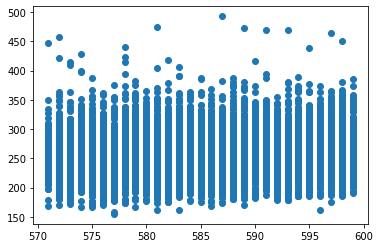

In [16]:
plt.scatter([len(x['code']) for x in samples[:10000]], [len(ids) for ids in numericalizer([x['code'] for x in samples[:10000]])['input_ids']])

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


KeyboardInterrupt: 

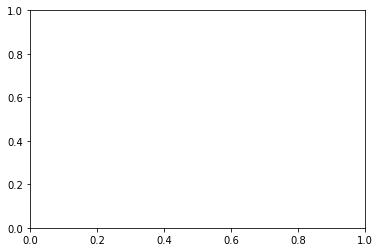

In [72]:
plt.hist(non_ascii_tok_lengths)

In [26]:
samples.sort(key=lambda smpl: len(smpl['code']), reverse=True)

In [45]:
code_ids = numericalizer([sample['code'] for sample in samples[:10000]])
np.argsort([len(ids) for ids in code_ids['input_ids']])[-10:]

array([7682, 9918,  669, 9871, 1029, 2104, 3094, 3484, 6343, 4174])

In [48]:
print(code[1029], len(code_ids['input_ids'][1029]))

def change_password(self, new_password):
        """
        修改教务密码, **注意** 合肥校区使用信息中心账号登录, 与教务密码不一致, 即使修改了也没有作用, 因此合肥校区帐号调用此接口会直接报错

        @structure bool

        :param new_password: 新密码
        """

        if self.session.campus == HF:
            raise ValueError('合肥校区使用信息中心账号登录, 修改教务密码没有作用')
        # 若新密码与原密码相同, 直接返回 True
        if new_password == self.session.password:
            raise ValueError('原密码与新密码相同')

        result = self.query(ChangePassword(self.session.password, new_password))
        if result:
            self.session.password = new_password
        return result 464


In [52]:
for batch in train_dataloader:
    print(batch['decoder_input_ids'])
    print(batch['decoder_target_ids'])
    print(batch['target_attention_mask'])
    print(torch.masked_select(batch['decoder_target_ids'], batch['target_attention_mask'].type(torch.bool)))
    break

tensor([[    0,  9232, 18134, 41087,  1215,   560,  1215, 48408,  1640, 41087,
          3256, 50118,  1437,  1437,  1437, 49434, 50118,  1437,  1437,  1437,
         32988,    10,   385, 34748,   128, 41087,   108,  7626,     7,    10,
         10798, 49683,    11,    36,  8766,     6,   235,     6,  2576,     6,
           314,    43,   645, 50140,  1437,  1437,  1437,  4832, 46669, 20705,
            35,    10,   385, 34748,   128, 41087,   108,  7626, 50118,  1437,
          1437,  1437,  4832, 30921,    35,    10, 10798, 49683,  8985,     9,
             5, 20705,    11,    36,  8766,     6,   235,     6,  2576,     6,
           314,    43,   645, 50118,  1437,  1437,  1437, 49434, 50118,  1437,
          1437,  1437,   671, 20705,     4,  8766, 49196, 20705,     4,  4070,
         49196, 20705,     4, 23724, 49196, 20705,     4,  6960, 43048,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,  

In [2]:
model = BART_Simple()

In [70]:
torch.save({'model':model, 'train_dataset':train_dataset}, 'BART_6k_chars.pickle')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BART_Simple. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BartForConditionalGeneration. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BartModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "

In [19]:
lengths = [len(train_dataset[i]['input_ids']) for i in tqdm(range(10000))]

In [50]:
class Saving_Calllback(Callback):
    def __init__(self, filepath, prefix='', epoch_save_interval=0.5):
        self.epoch_save_interval = epoch_save_interval
        self.next_save_batch_idx = 0
        self.filepath = filepath
        self.prefix = prefix
        
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        
    def on_batch_end(self, trainer, pl_module):
        if trainer.batch_idx >= self.next_save_batch_idx:
            if trainer.limit_train_batches:
                total_steps = len(trainer.train_dataloader) * trainer.limit_train_batches
            else: 
                total_steps = len(trainer.train_dataloader)
            
            filepath=os.path.join(self.filepath, f"{self.prefix}_step_{trainer.batch_idx}.ckpt")
            trainer.save_checkpoint(filepath)
            self.next_save_batch_idx += total_steps*self.epoch_save_interval
saving_cb = Saving_Calllback(filepath='./saved_models/BART_CodeSearchNet/',
                             prefix="BART_test",
                             epoch_save_interval=1)

In [51]:
trainer = Trainer(gpus=[1], gradient_clip_val=0.5, amp_level='O1', limit_train_batches=0.001, max_epochs=1, checkpoint_callback=checkpoint_callback, 
                  callbacks=[saving_cb])
trainer.fit(model, train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                         | Params
------------------------------------------------------
0 | BART | BartForConditionalGeneration | 406 M 


1

In [61]:
BART_cond_gen_transform = BART_Conditional_Generator_Transform("./saved_models/BART_CodeSearchNet/BART_600_step_9246.ckpt")

Running model on cuda


In [62]:
# Complete the string bellow
test_samples = [{'input_text':
                 '''
def contains_number(x):
    """A function to check if x is a number"""
'''}]
returned_samples = BART_cond_gen_transform(test_samples)
print(returned_samples[0]['pred_text'])


def contains_number(x):
    """A function to check if x is a number."""
  return x.as_number()

   return 0.0.1.0(1, x) or 1, 2, 3


# Data Augmentation

In [77]:
numer_samples = BART_Numericalise_Transform(fields=[('code', 'input_ids')], use_ray=False)(samples[:10000])

In [78]:
max([len(s['input_ids']) for s in numer_samples])

473

In [298]:
augmented_samples = Code_Sample_Augmentation_Transform()(samples)

2020-09-08 15:44:44,635	ERROR worker.py:666 -- Calling ray.init() again after it has already been called.


In [300]:
sample_lengths = [len(sample['code']) for sample in augmented_samples]

In [5]:
large_samples = list([{'code':'foo '*40}]*4000)
large_samples += list([{'code':'foo '*40}]*20)
dataset = BART_Span_Prediction_dataset(large_samples)
max_batch_dataloader = dataset.to_dataloader(16)

In [17]:
max(len(s['input_ids']) for s in dataset)

137

In [18]:
model.batch_size = 1
model.train_dataloader = lambda: dataset.to_dataloader(model.batch_size)

In [7]:
trainer = Trainer(gpus=1, gradient_clip_val=0.5, amp_level='O1', max_epochs=100)# , auto_scale_batch_size='binsearch')
trainer.fit(model, max_batch_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                         | Params
------------------------------------------------------
0 | BART | BartForConditionalGeneration | 406 M 


Saving latest checkpoint..


1